This notebook contains all the tweet and user based final analysis for data that includes bot related tweets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Loading and processing the data, creating the extra features

In [2]:
data_unprocessed_wo_bots = pd.read_csv("/home/ubuntu/Masters Thesis/data/final/raw_data/Bitcoin_twitter_data_english_non_textprocessed_botremovedtweets.csv", lineterminator='\n')
data_unprocessed_wo_bots.drop(columns=["Unnamed: 0", "user_location", "user_description"], inplace=True)

In [3]:
data_unprocessed_wo_bots['date'] = pd.to_datetime(data_unprocessed_wo_bots['date'])
data_unprocessed_wo_bots['user_created'] = pd.to_datetime(data_unprocessed_wo_bots['user_created'])
data_unprocessed_wo_bots['user_age'] = (data_unprocessed_wo_bots["date"] - data_unprocessed_wo_bots["user_created"]).dt.days

Tweet based analysis

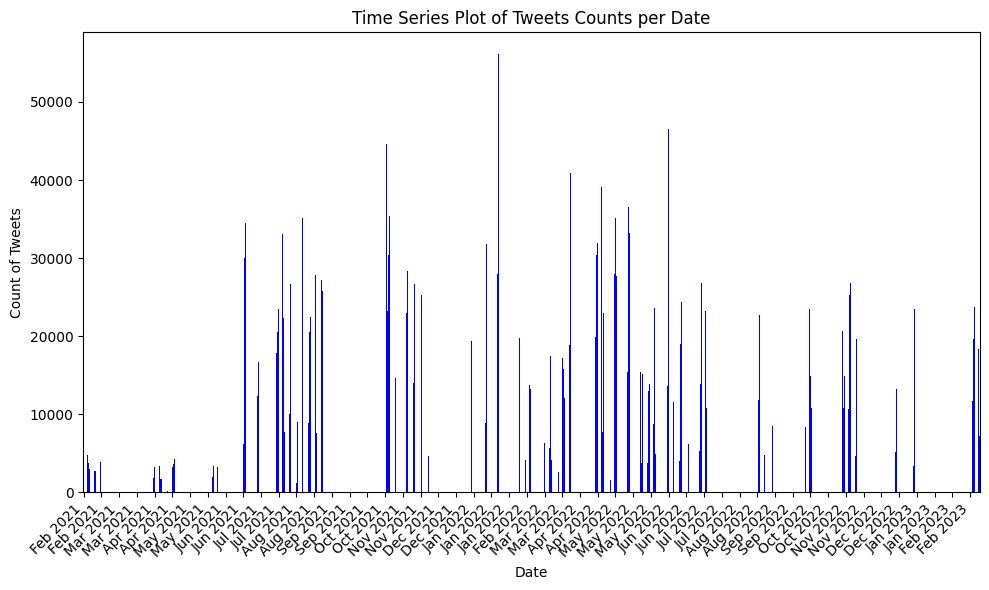

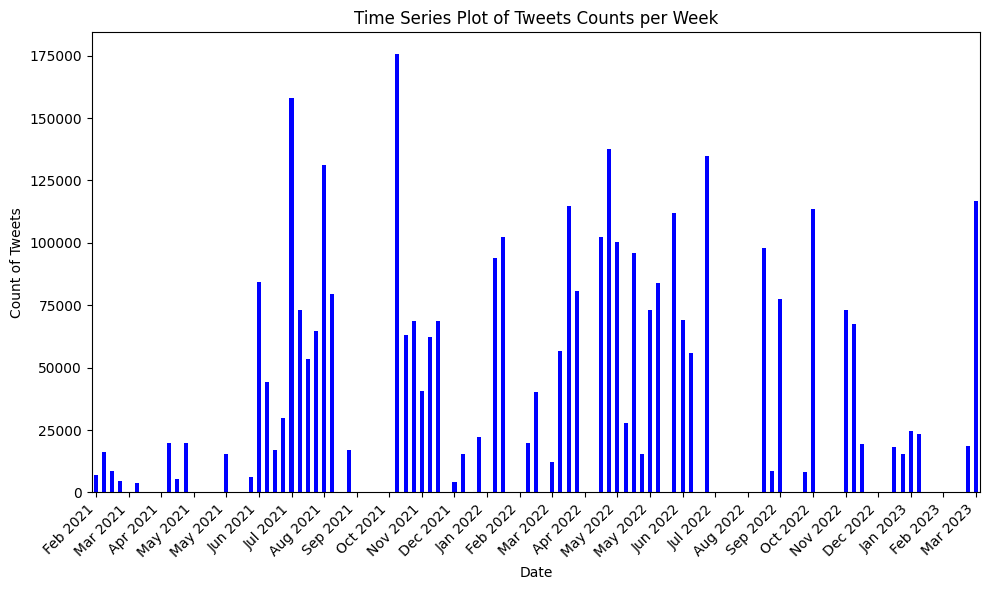

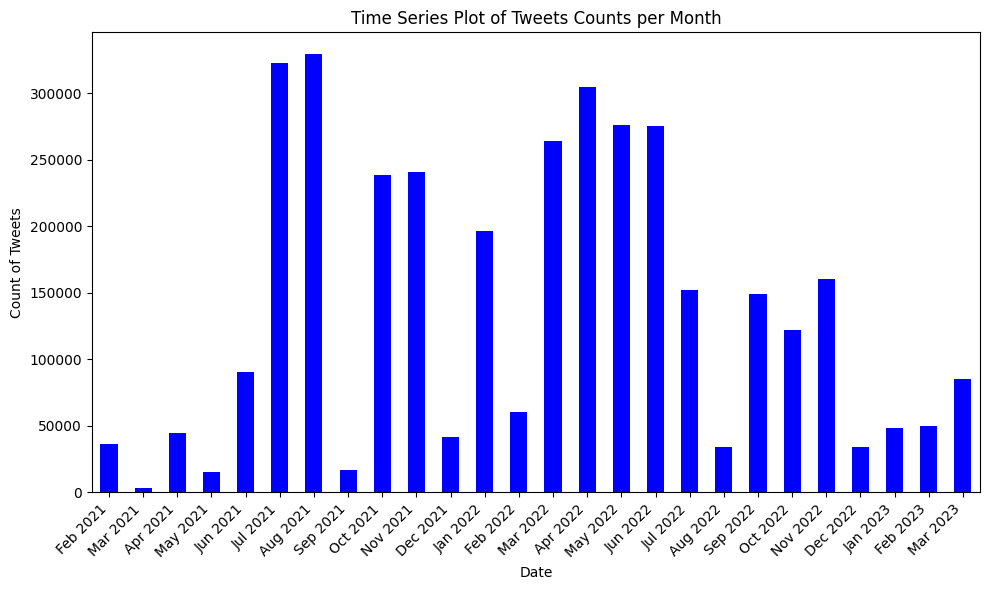

In [5]:
frequency_dict = {'D': ["Date", 15], 'W': ["Week", 4], 'M':["Month", 1]}
def create_tweet_count_by_date_plot(data, frequency):
    counts_per_date = data.resample(frequency, on='date').size()
    # Create a time series plot
    plt.figure(figsize=(10, 6))
    counts_per_date.plot(kind='bar', color='b')
    plt.xlabel('Date')
    plt.ylabel('Count of Tweets')
    plt.title(f'Time Series Plot of Tweets Counts per {frequency_dict[frequency][0]}')
    plt.xticks(rotation=45, ha='right')
    n = frequency_dict[frequency][1]  # Display every n-th label
    labels = [label.strftime('%b %Y') for i, label in enumerate(counts_per_date.index) if i % n == 0]
    plt.xticks(range(0, len(counts_per_date), n), labels)
    plt.tight_layout()
    plt.show()
    
create_tweet_count_by_date_plot(data_unprocessed_wo_bots, 'D')
create_tweet_count_by_date_plot(data_unprocessed_wo_bots, 'W')
create_tweet_count_by_date_plot(data_unprocessed_wo_bots, 'M')

User based Data Analysis

In [6]:
user_data = data_unprocessed_wo_bots[["date", "user_name", "user_age", "user_followers", "user_friends", "user_favourites", "user_verified"]]

# create user influence metric
user_data['user_influence'] = ((user_data['user_followers']+1)/(np.log(user_data['user_friends']+1)+1))*(user_data['user_favourites']+1)*(user_data["user_verified"]+1)

# create percentile bins
percentiles = [0, 25, 50, 75, 90, 95, 99, 100]
follower_bins = np.percentile(user_data['user_followers'], percentiles)
friends_bins = np.percentile(user_data['user_friends'], percentiles)
favourite_bins = np.percentile(user_data['user_favourites'], percentiles)
userage_bins = np.percentile(user_data['user_age'], percentiles)
userinfluence_bins = np.percentile(user_data['user_influence'], percentiles)

1. Unique Users

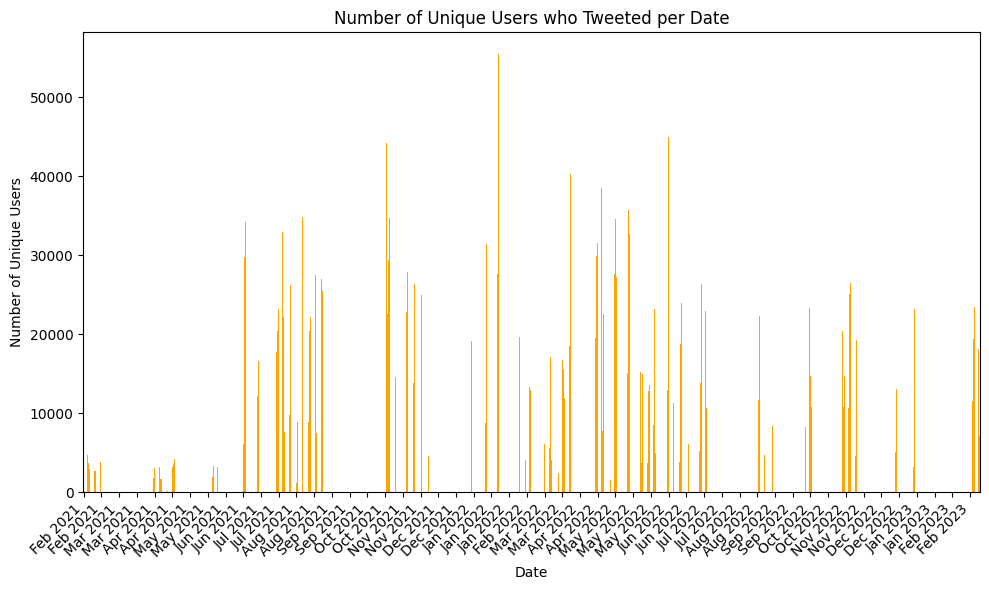

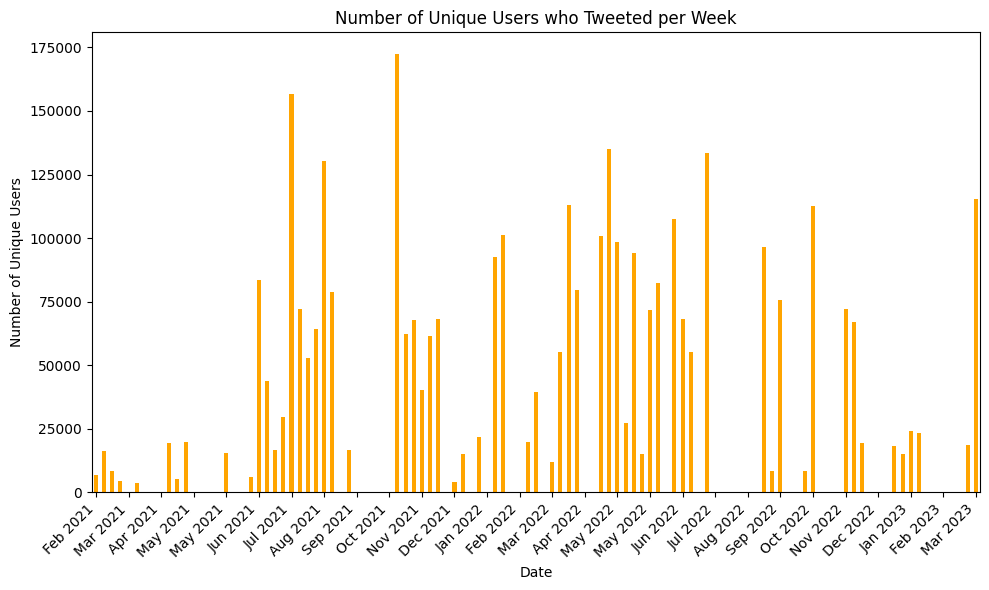

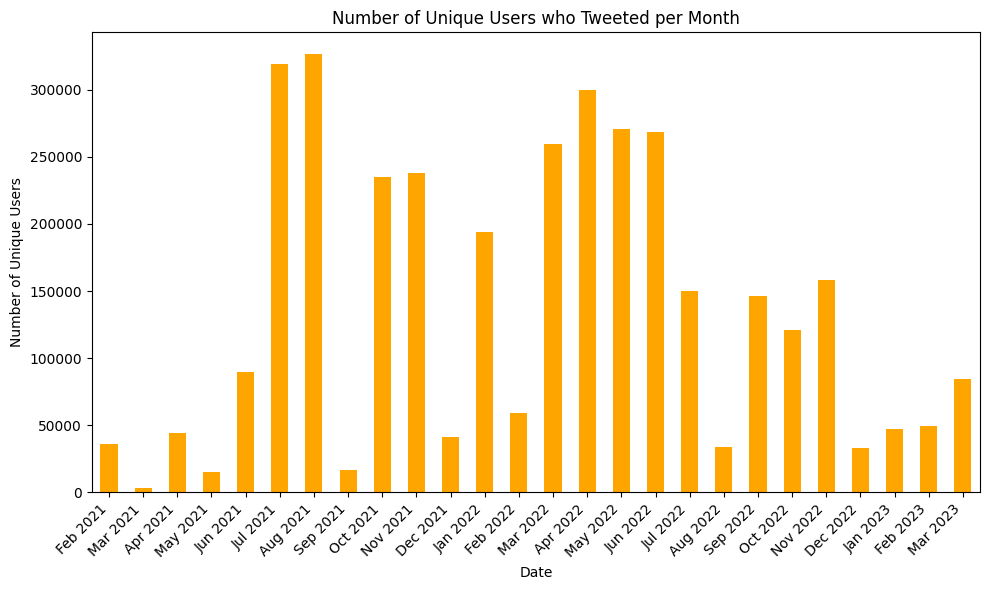

In [7]:
def create_unique_user_barplot(user_data, frequency):
    # frequency can be 'D', 'W', 'M'
    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name']).resample(frequency, on='date').size()
    plt.figure(figsize=(10, 6))
    unique_users_per_date.plot(kind='bar', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Number of Unique Users')
    plt.title(f'Number of Unique Users who Tweeted per {frequency_dict[frequency][0]}')
    plt.xticks(rotation=45, ha='right')
    n = frequency_dict[frequency][1]  # Display every n-th label
    labels = [label.strftime('%b %Y') for i, label in enumerate(unique_users_per_date.index) if i % n == 0]
    plt.xticks(range(0, len(unique_users_per_date), n), labels)
    plt.tight_layout()
    plt.show()
    
create_unique_user_barplot(user_data, "D")
create_unique_user_barplot(user_data, "W")
create_unique_user_barplot(user_data, "M")

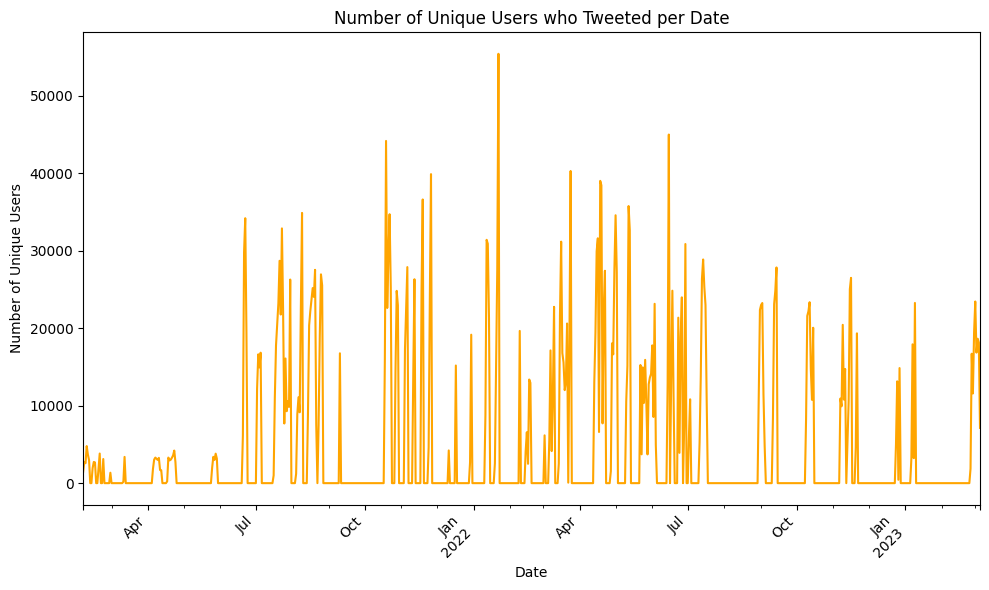

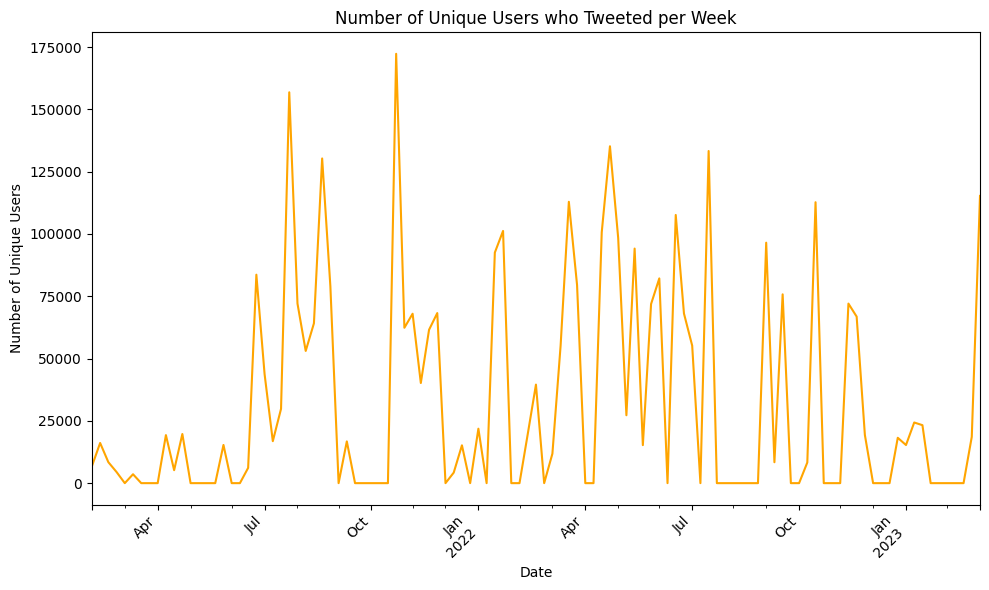

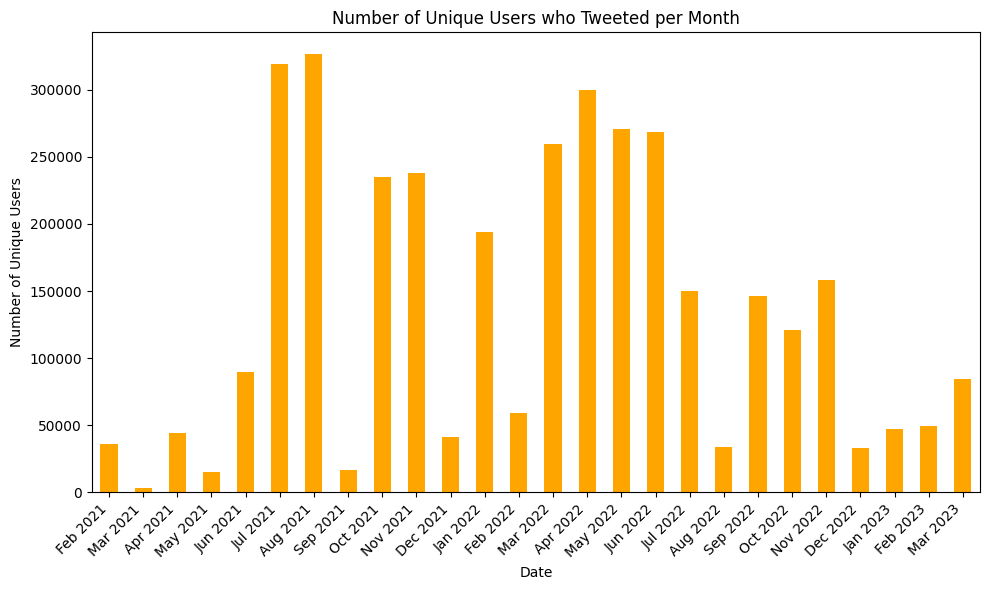

In [8]:
def create_unique_user_lineplot(user_data, frequency):
    # frequency can be 'D', 'W', 'M'
    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name']).resample(frequency, on='date').size()
    plt.figure(figsize=(10, 6))
    unique_users_per_date.plot(kind='line', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Number of Unique Users')
    plt.title(f'Number of Unique Users who Tweeted per {frequency_dict[frequency][0]}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
create_unique_user_lineplot(user_data, "D")
create_unique_user_lineplot(user_data, "W")
create_unique_user_barplot(user_data, "M")

2. Number of Followers, Friends, Favourites, User Age, User Influence

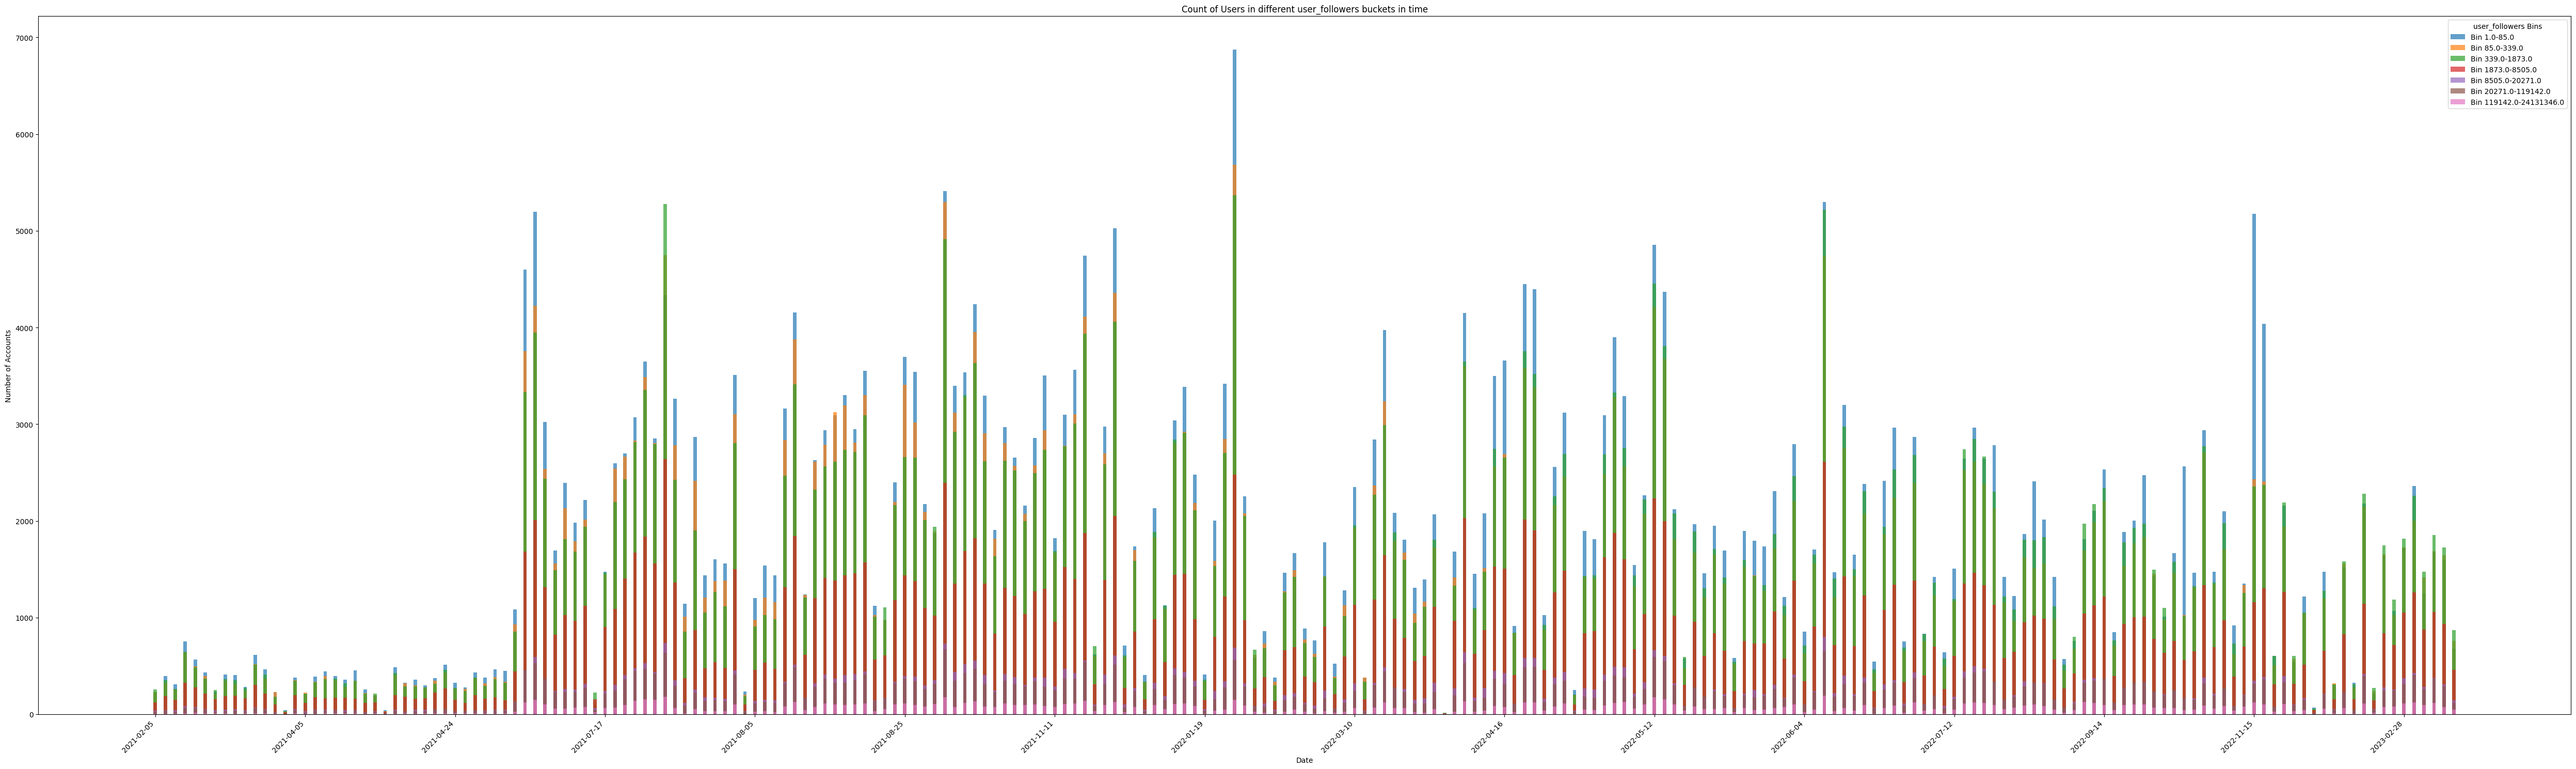

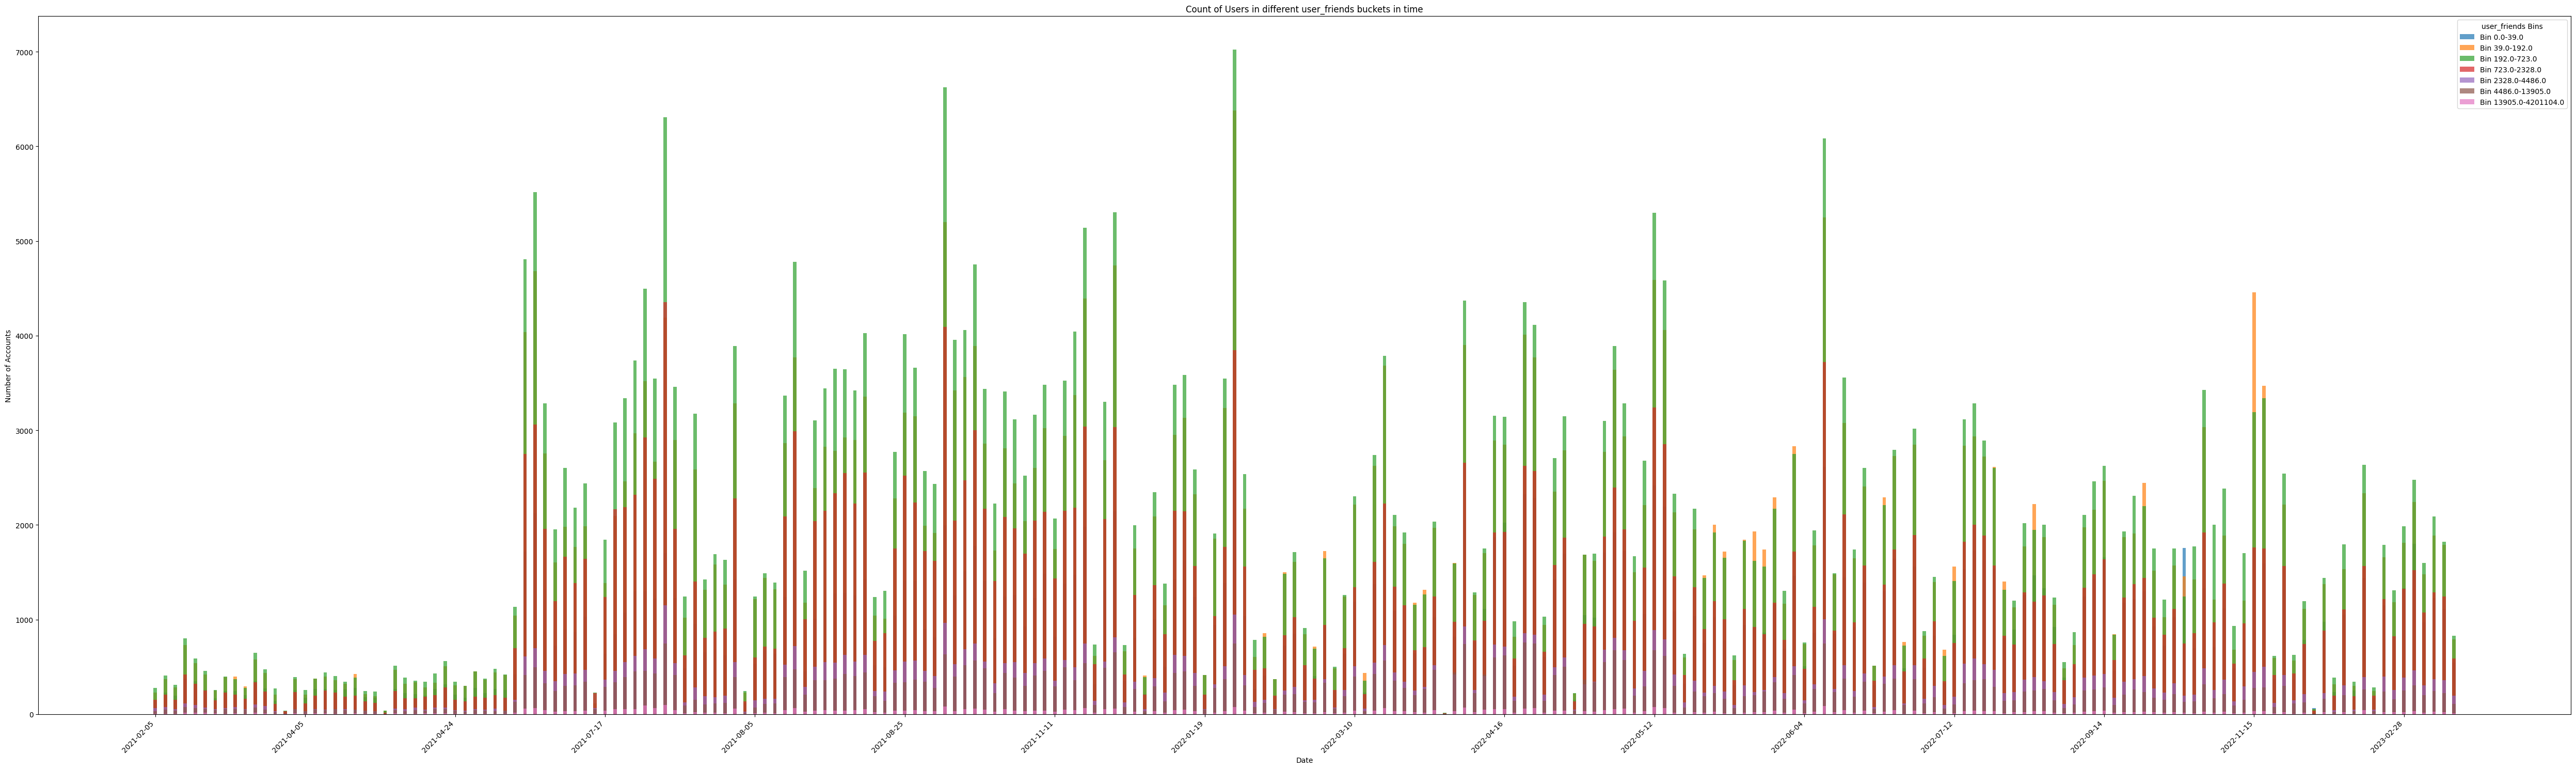

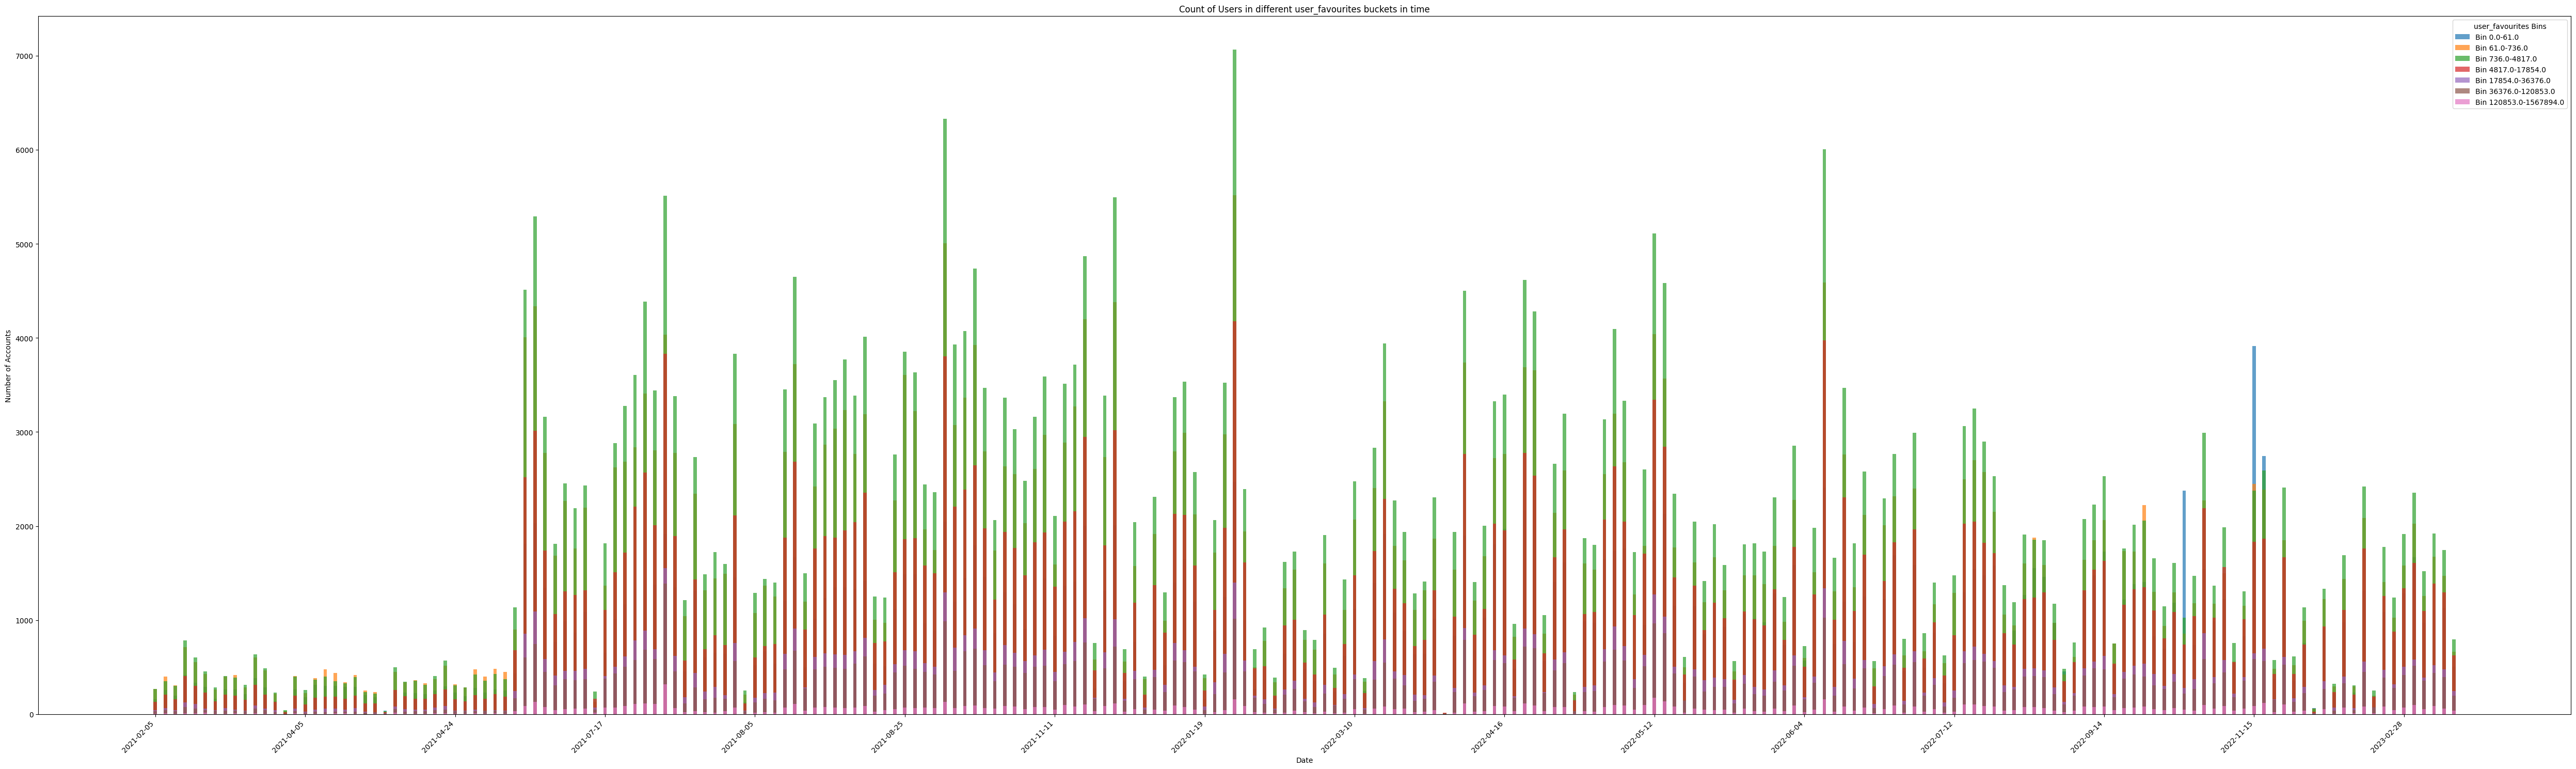

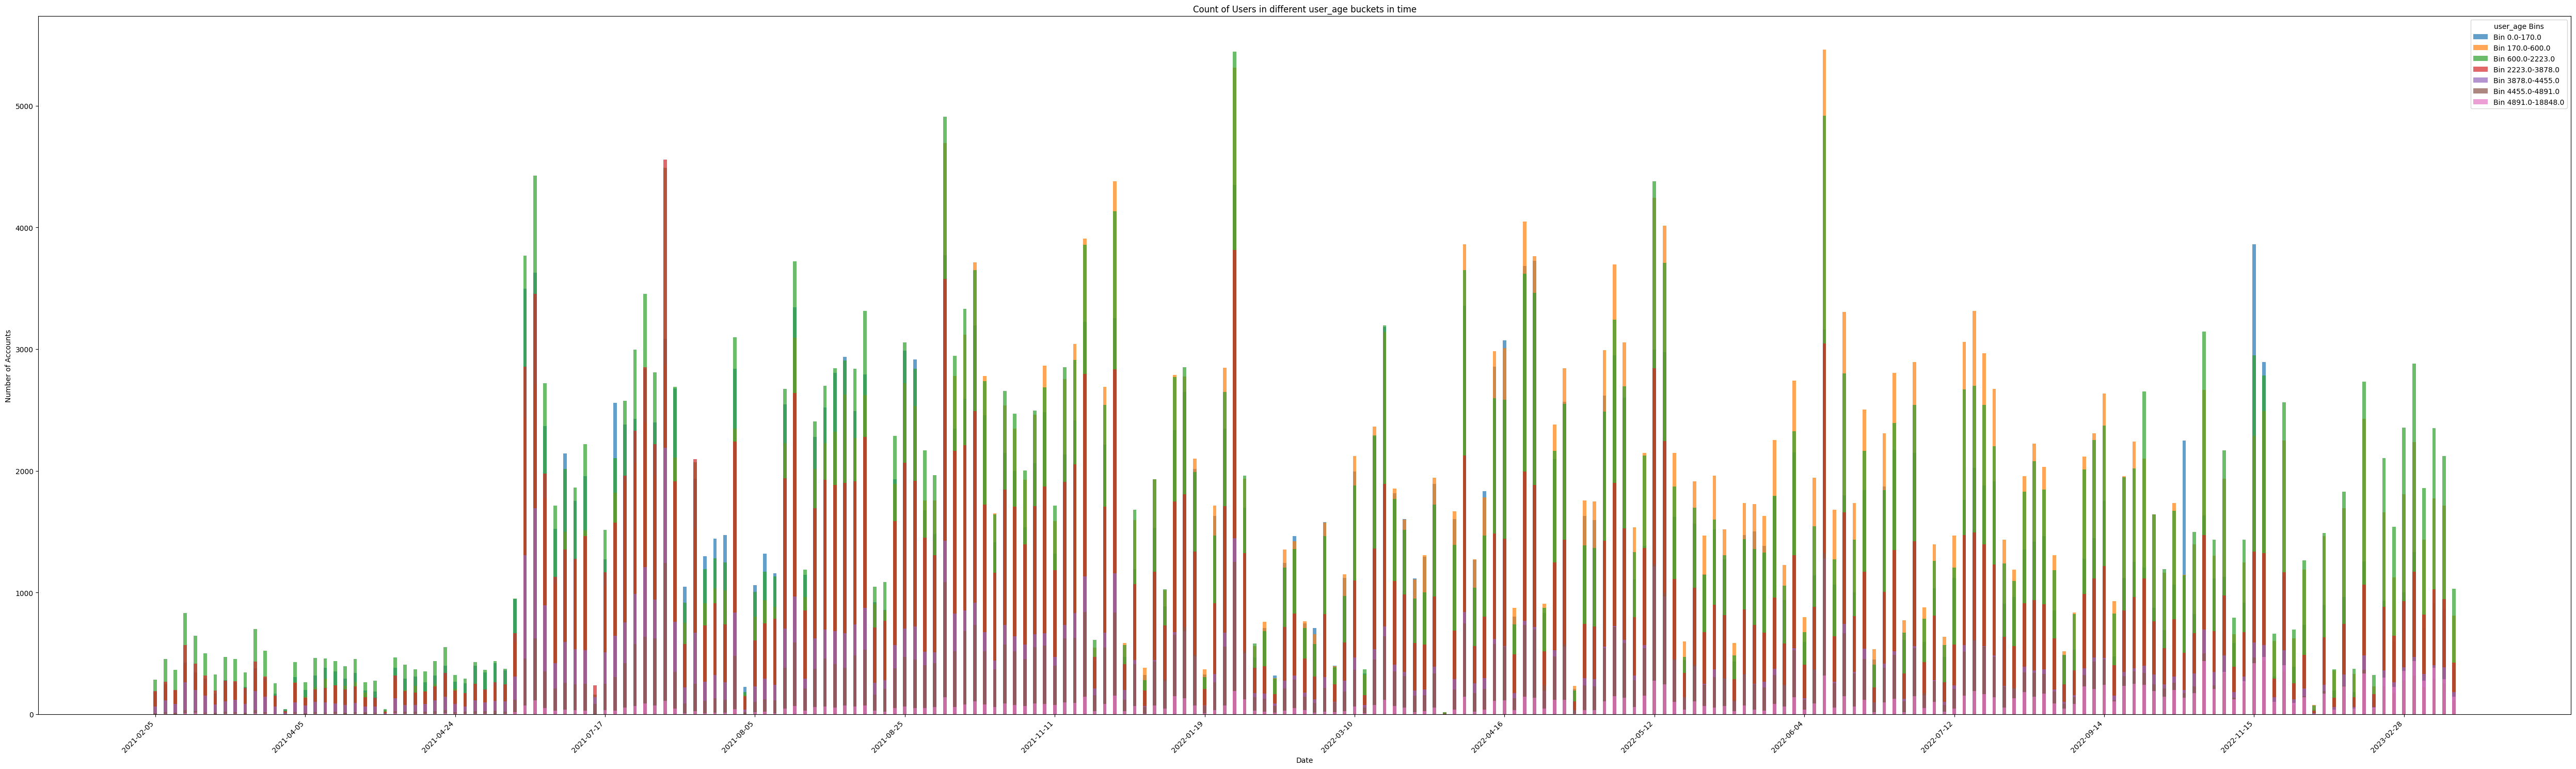

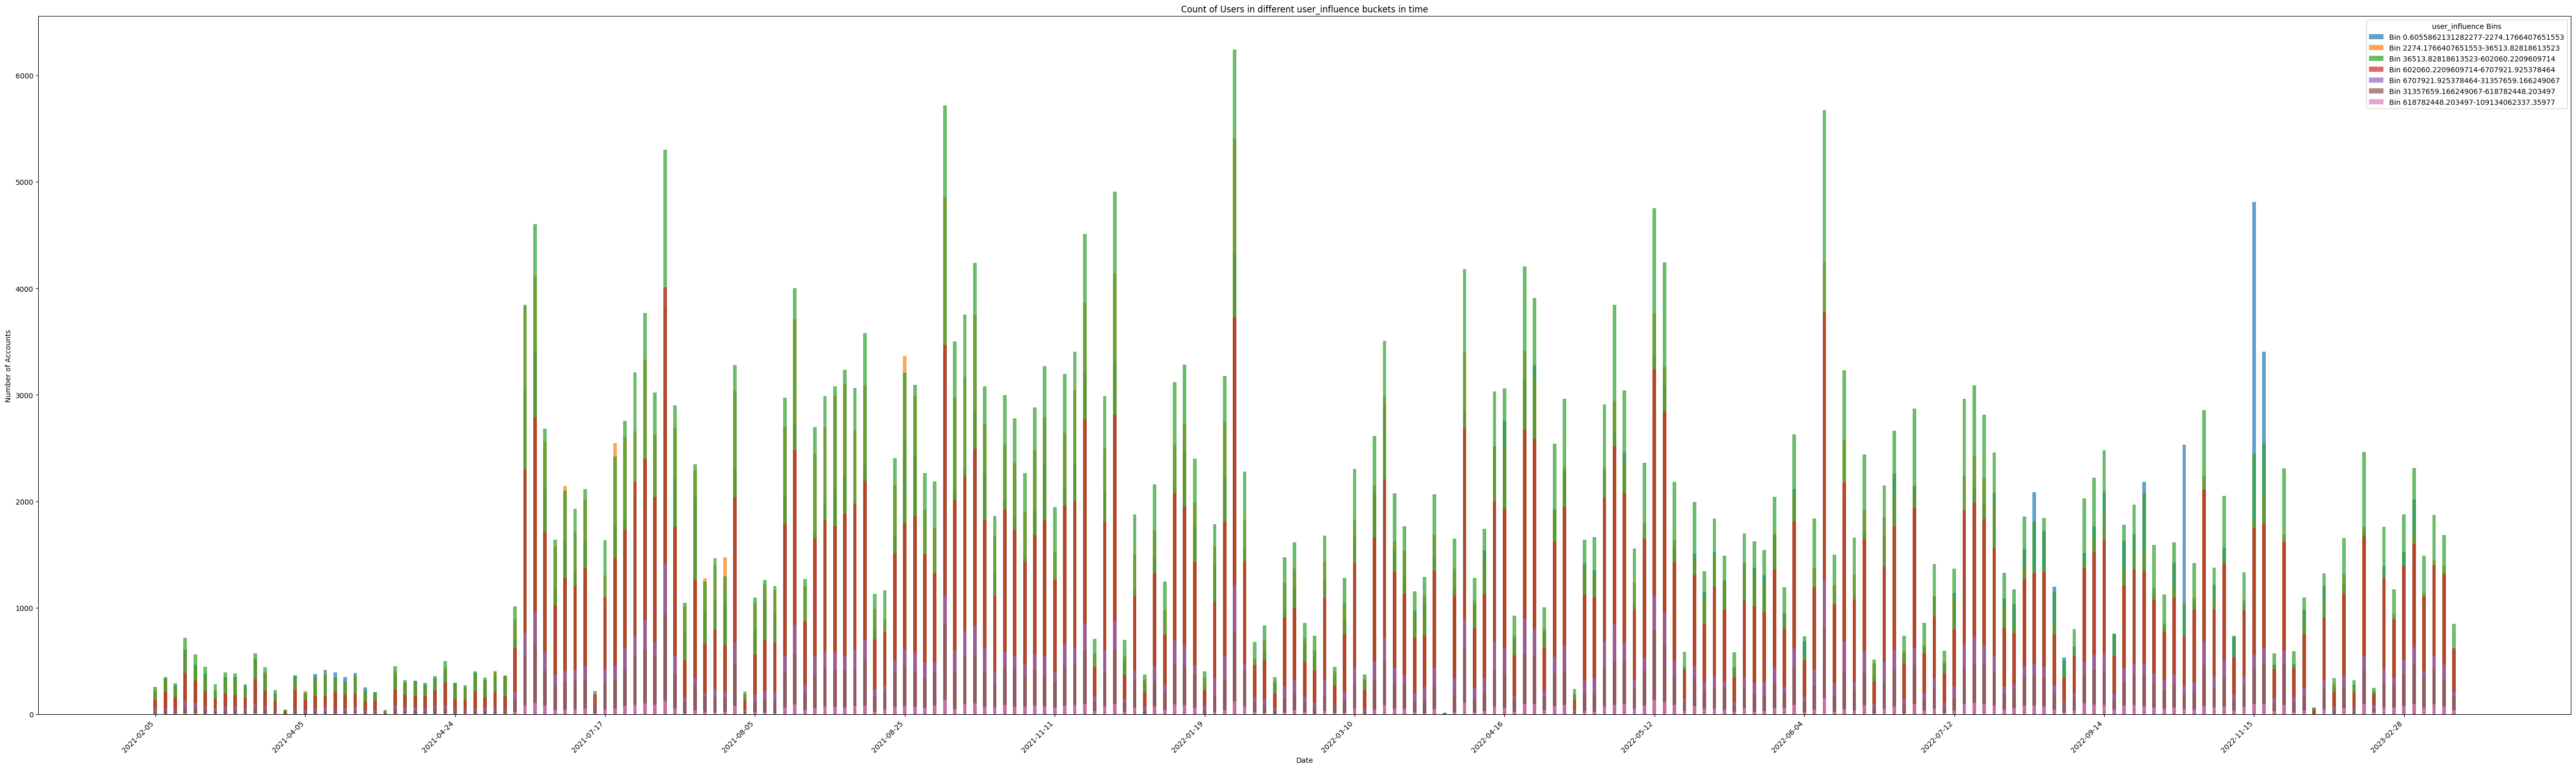

In [9]:
def make_stacked_barplot_with_bins_by_date(user_data, metric, bins):

    fig, ax = plt.subplots(figsize=(50, 15))

    hist_data = []
    labels = []

    user_data['date'] = pd.to_datetime(user_data['date']).dt.date
    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name'])

    for date, group in unique_users_per_date.groupby('date'):
        followers_histogram, _ = np.histogram(group[metric], bins=bins)
        hist_data.append(followers_histogram)
        labels.append(date)

    hist_data = np.vstack(hist_data)

    # Create a stacked bar chart
    bar_width = 0.35
    index = range(len(labels))

    for i in range(len(bins) - 1):
        ax.bar(index, hist_data[:, i], width=bar_width, label=f'Bin {bins[i]}-{bins[i+1]}', alpha=0.7)

    # Adding labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Accounts')
    ax.set_title('Stacked Histogram of Binned Followers for Each Day')

    # Add legend
    ax.legend(title=f'{metric} Bins', loc='upper right')
    ax.set_xticks(index)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    plt.title(f"Count of Users in different {metric} buckets in time")

    n = 15  # Display every n-th label
    xlabels = [label for i, label in enumerate(labels) if i % n == 0]
    plt.xticks(range(0, len(labels), n), xlabels)
    plt.tight_layout()
    # Display the plot
    plt.show()
    
make_stacked_barplot_with_bins_by_date(user_data, "user_followers", follower_bins)
make_stacked_barplot_with_bins_by_date(user_data, "user_friends", friends_bins)
make_stacked_barplot_with_bins_by_date(user_data, "user_favourites", favourite_bins)
make_stacked_barplot_with_bins_by_date(user_data, "user_age", userage_bins)
make_stacked_barplot_with_bins_by_date(user_data, "user_influence", userinfluence_bins)

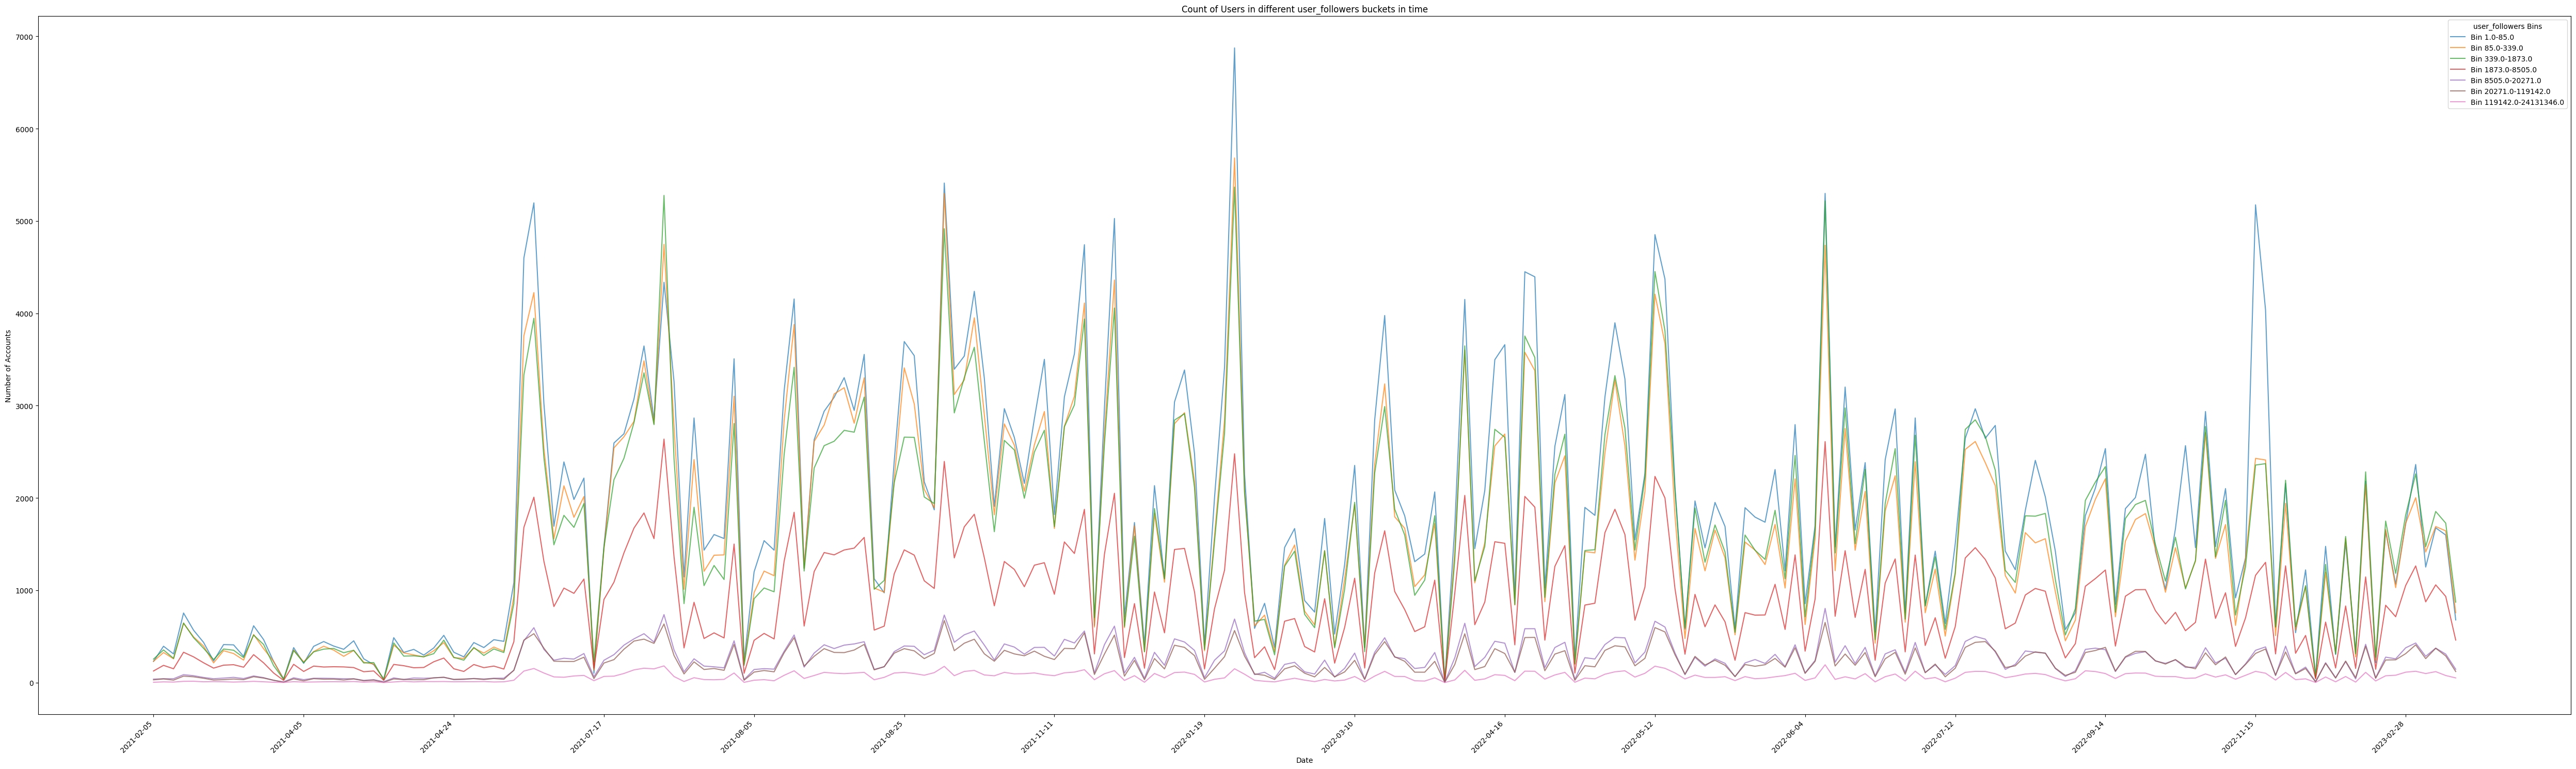

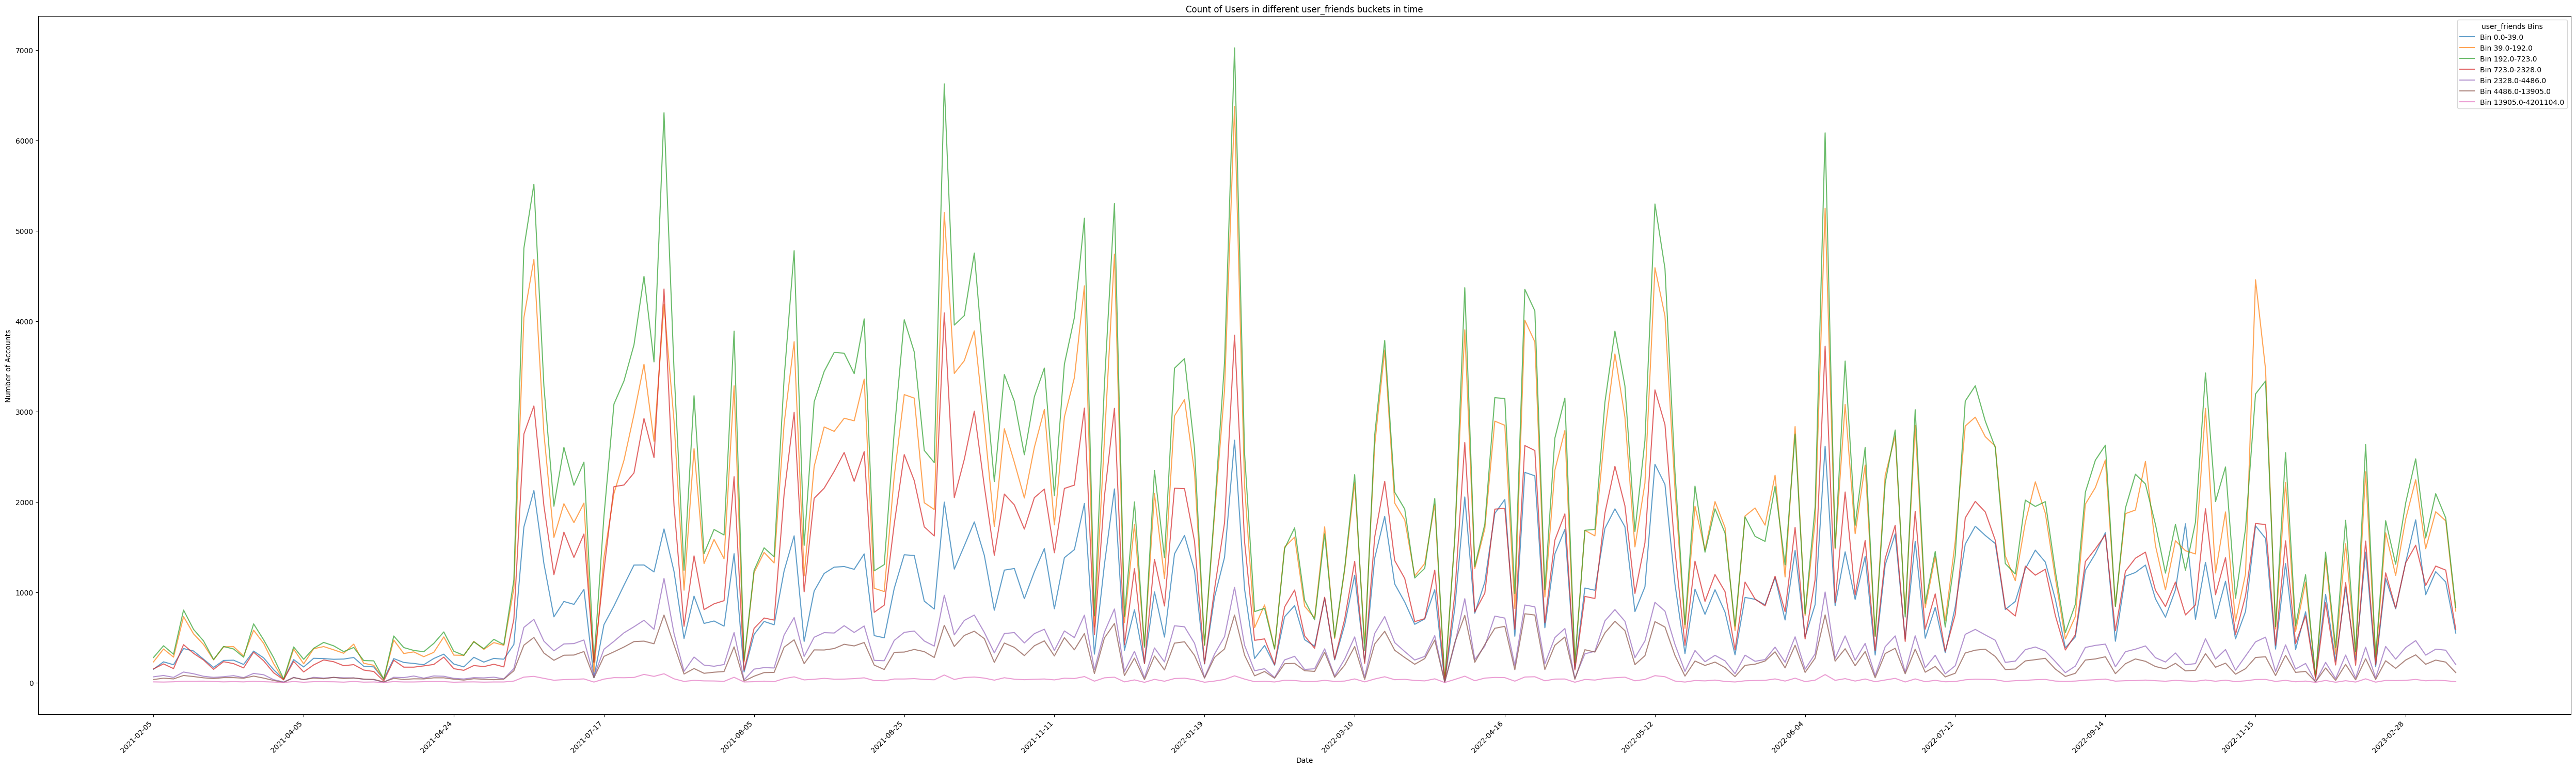

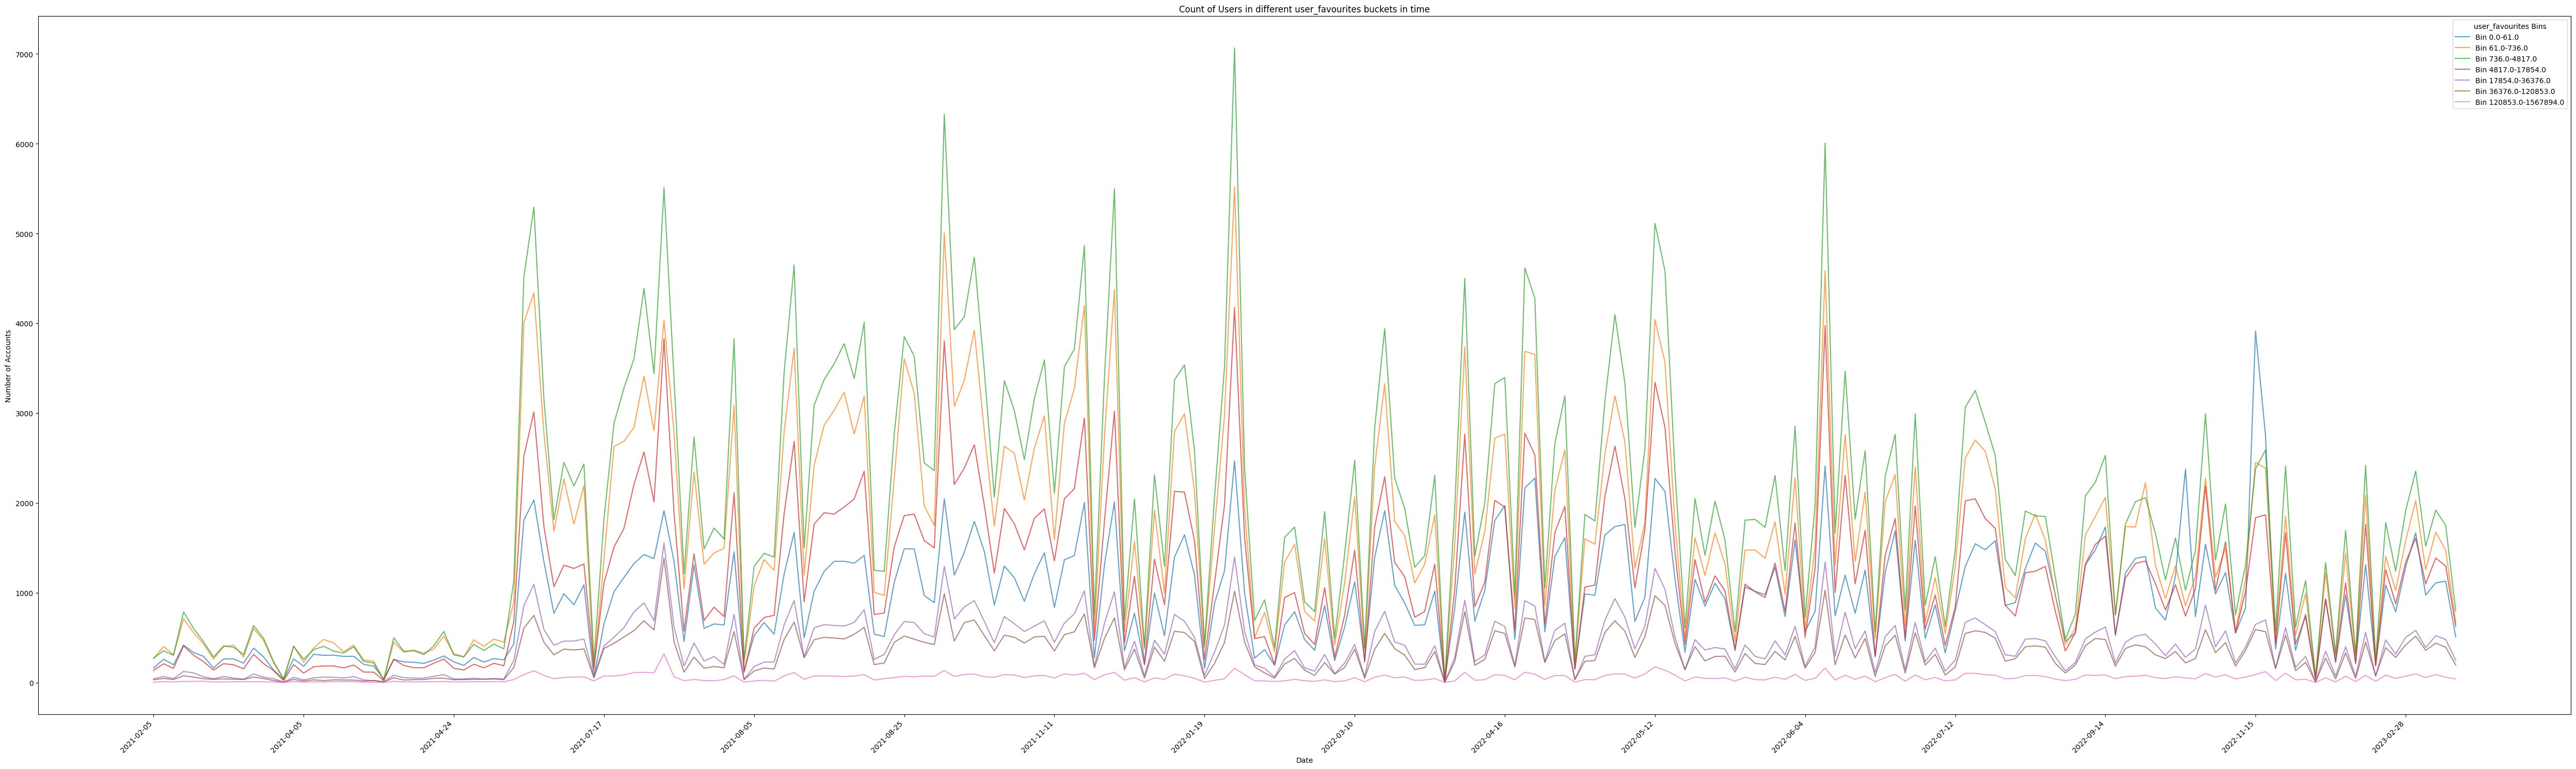

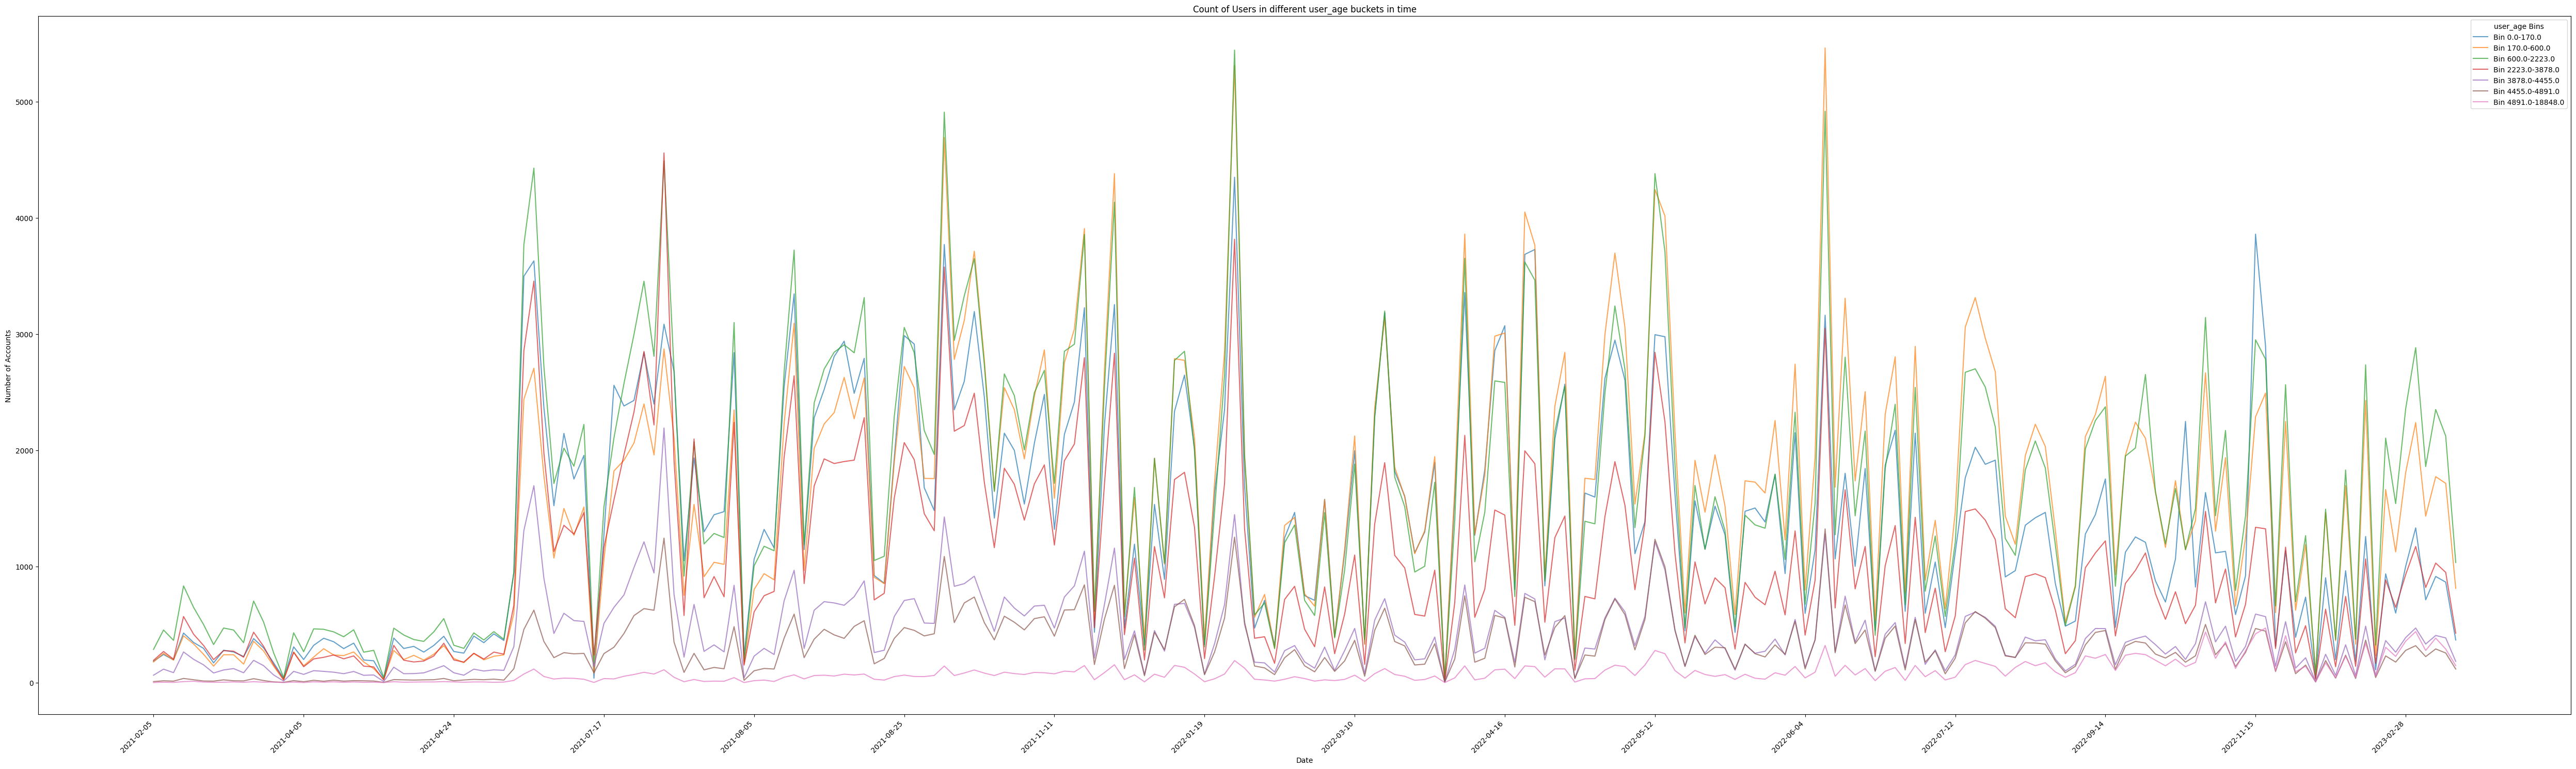

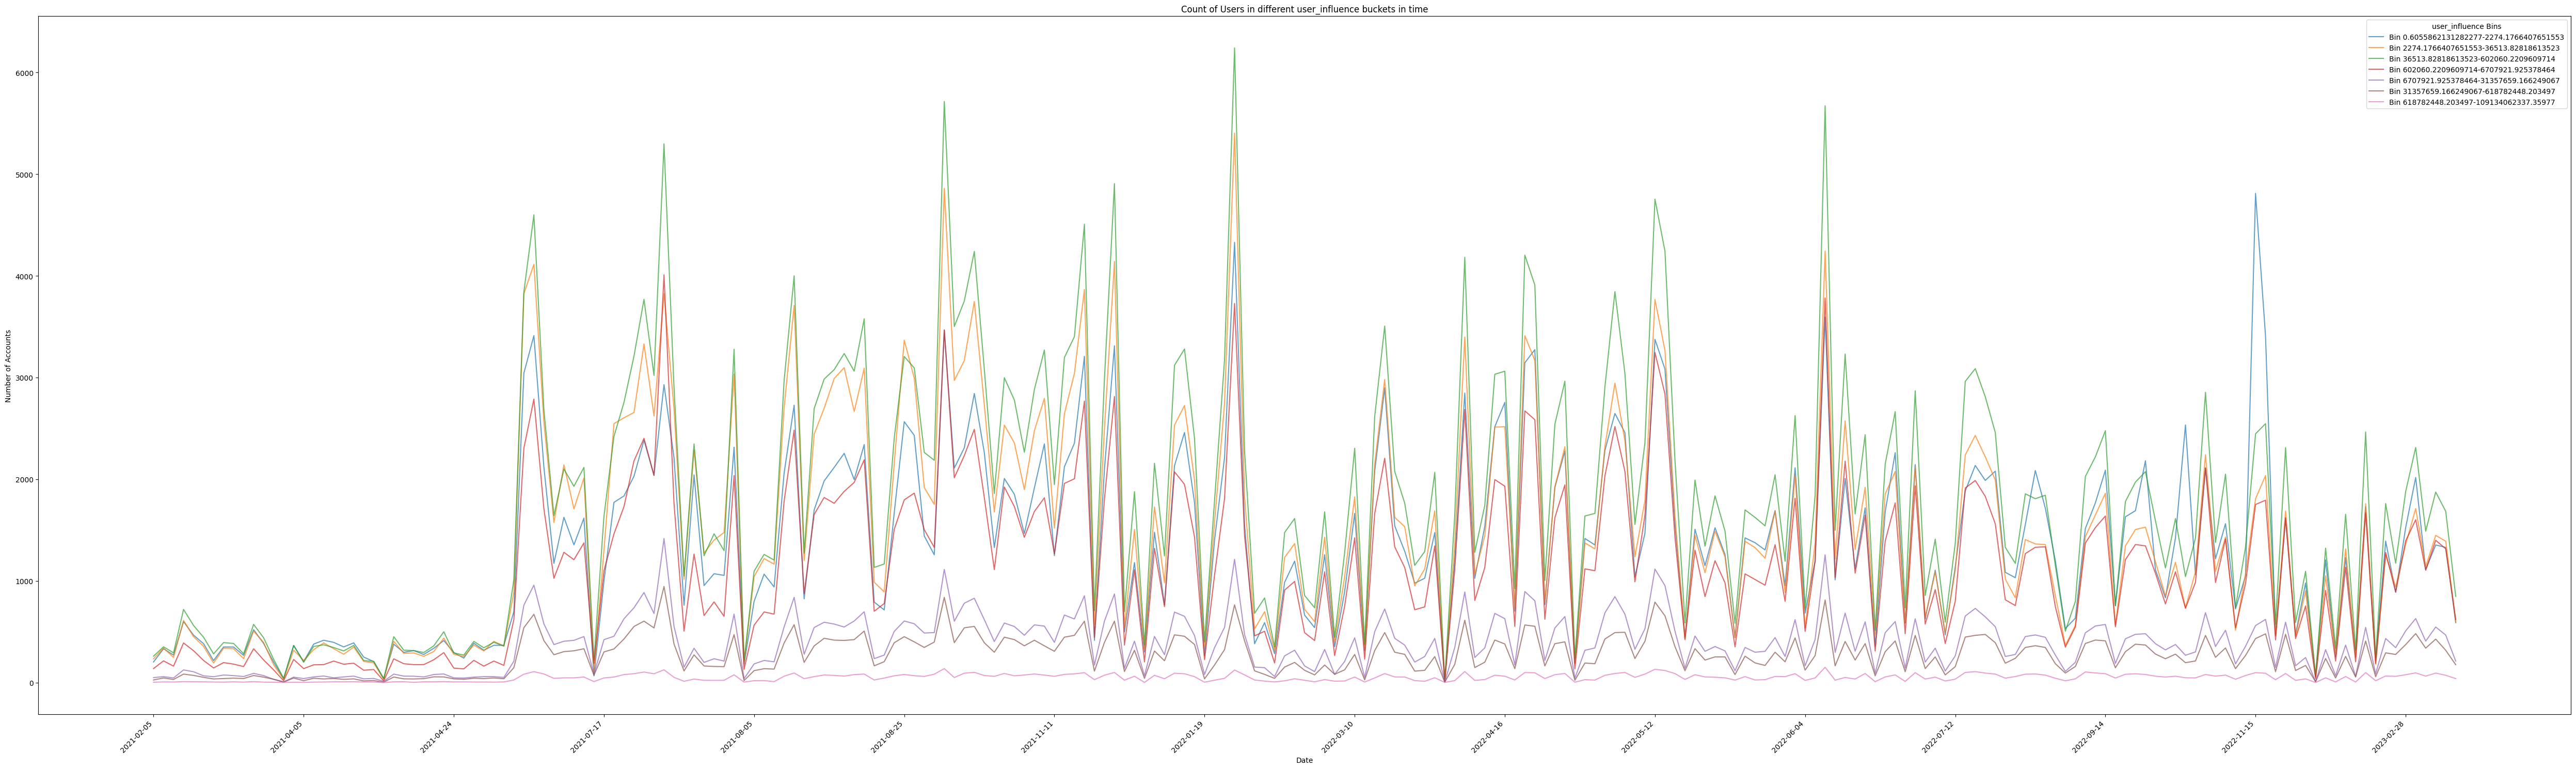

In [10]:
def make_lineplot_with_bins_by_date(user_data, metric, bins):

    fig, ax = plt.subplots(figsize=(50, 15))

    hist_data = []
    labels = []

    user_data['date'] = pd.to_datetime(user_data['date']).dt.date
    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name'])

    for date, group in unique_users_per_date.groupby('date'):
        followers_histogram, _ = np.histogram(group[metric], bins=bins)
        hist_data.append(followers_histogram)
        labels.append(date)

    hist_data = np.vstack(hist_data)

    index = range(len(labels))

    for i in range(len(bins) - 1):
        ax.plot(index, hist_data[:, i], label=f'Bin {bins[i]}-{bins[i+1]}', alpha=0.7)

    # Adding labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Accounts')
    ax.set_title('Stacked Histogram of Binned Followers for Each Day')

    # Add legend
    ax.legend(title=f'{metric} Bins', loc='upper right')
    ax.set_xticks(index)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    plt.title(f"Count of Users in different {metric} buckets in time")

    n = 15  # Display every n-th label
    xlabels = [label for i, label in enumerate(labels) if i % n == 0]
    plt.xticks(range(0, len(labels), n), xlabels)
    plt.tight_layout()
    # Display the plot
    plt.show()
    
make_lineplot_with_bins_by_date(user_data, "user_followers", follower_bins)
make_lineplot_with_bins_by_date(user_data, "user_friends", friends_bins)
make_lineplot_with_bins_by_date(user_data, "user_favourites", favourite_bins)
make_lineplot_with_bins_by_date(user_data, "user_age", userage_bins)
make_lineplot_with_bins_by_date(user_data, "user_influence", userinfluence_bins)

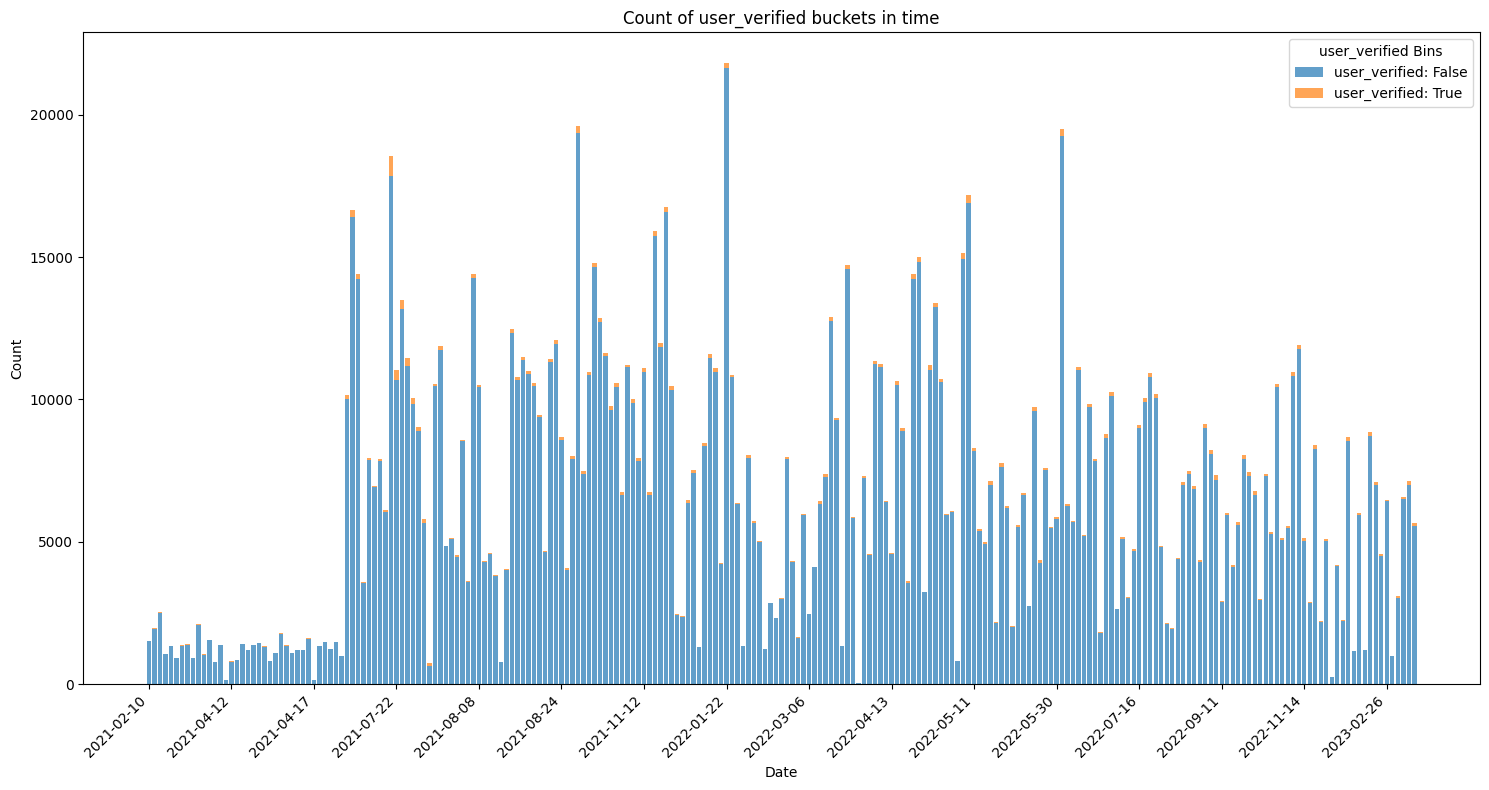

In [11]:
def create_stacked_boolean_plots(user_data, metric):

    fig, ax = plt.subplots(figsize=(15, 8))

    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name'])
    bar_width = 0.8
    unique_dates = unique_users_per_date['date'].unique()
    index = range(len(unique_users_per_date['date'].unique()))
    unique_values = unique_users_per_date[metric].unique()

    bottom = np.zeros(len(index))

    for value in unique_values:
        group = unique_users_per_date[unique_users_per_date[metric] == value]
        reindexed_group = group.groupby('date').size().reindex(unique_dates, fill_value=0)
        ax.bar(index, reindexed_group, width=bar_width, bottom=bottom, label=f'{metric}: {value}', alpha=0.7)
        bottom += reindexed_group

    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Stacked Bar Plot of {metric} Over Time')
    ax.legend(title=f'{metric} Bins', loc='upper right')
    ax.set_xticks(index)
    ax.set_xticklabels(unique_dates, rotation=45, ha='right')
    plt.title(f"Count of {metric} buckets in time")
    plt.xticks(rotation=45, ha='right')
    n = 15  # Display every n-th label
    xlabels = [label for i, label in enumerate(unique_dates) if i % n == 0]
    plt.xticks(range(0, len(unique_dates), n), xlabels)
    plt.tight_layout()
    plt.show()

create_stacked_boolean_plots(user_data, "user_verified")
# create_stacked_boolean_plots(data_unprocessed, "is_retweet")

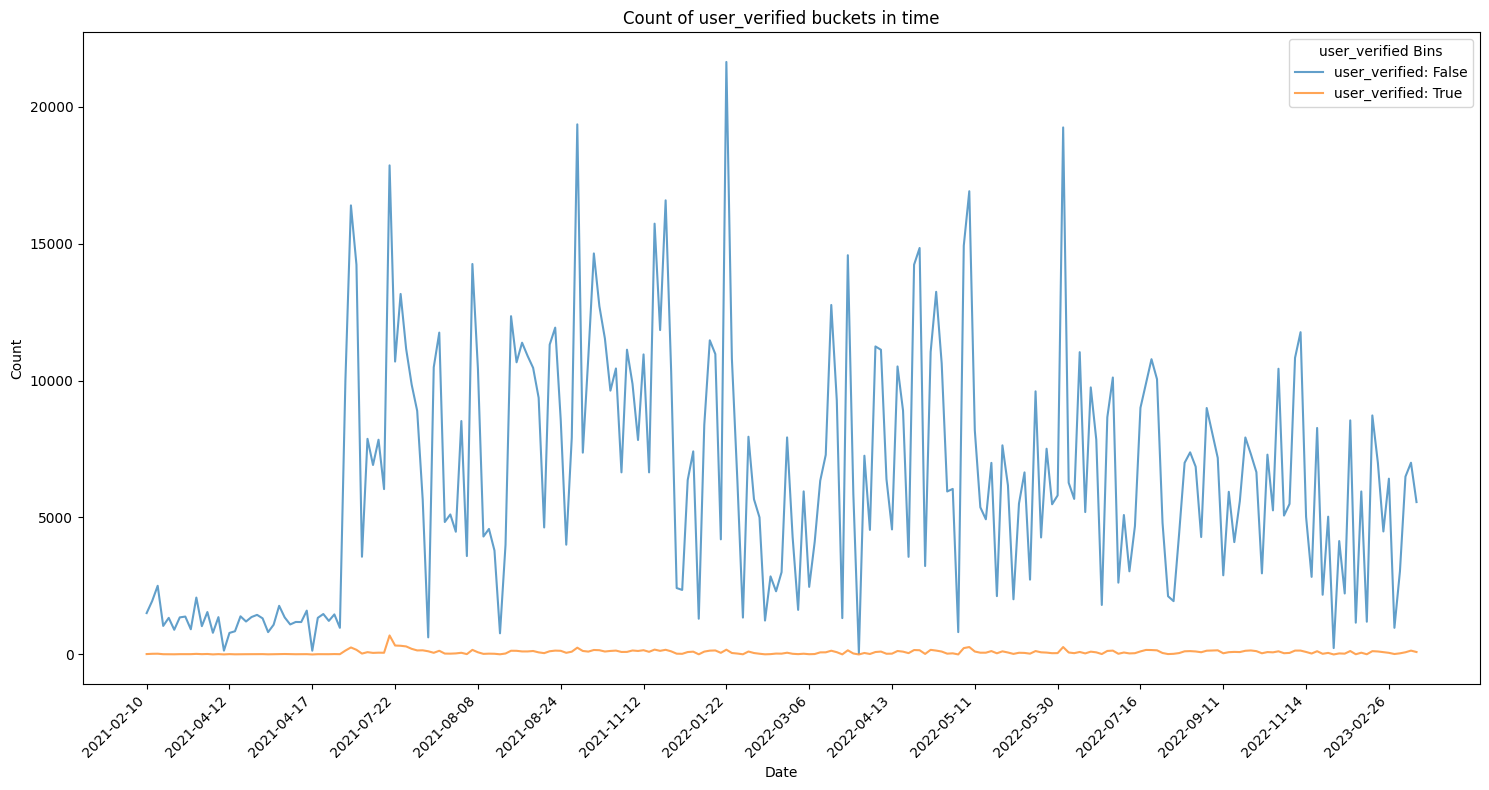

In [12]:
def create_boolean_lineplots(user_data, metric):

    fig, ax = plt.subplots(figsize=(15, 8))

    unique_users_per_date = user_data.drop_duplicates(subset=['date', 'user_name'])
    unique_dates = unique_users_per_date['date'].unique()
    index = range(len(unique_users_per_date['date'].unique()))
    unique_values = unique_users_per_date[metric].unique()

    bottom = np.zeros(len(index))

    for value in unique_values:
        group = unique_users_per_date[unique_users_per_date[metric] == value]
        reindexed_group = group.groupby('date').size().reindex(unique_dates, fill_value=0)
        ax.plot(index, reindexed_group, label=f'{metric}: {value}', alpha=0.7)
        bottom += reindexed_group

    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Stacked Bar Plot of {metric} Over Time')
    ax.legend(title=f'{metric} Bins', loc='upper right')
    ax.set_xticks(index)
    ax.set_xticklabels(unique_dates, rotation=45, ha='right')
    plt.title(f"Count of {metric} buckets in time")
    plt.xticks(rotation=45, ha='right')
    n = 15  # Display every n-th label
    xlabels = [label for i, label in enumerate(unique_dates) if i % n == 0]
    plt.xticks(range(0, len(unique_dates), n), xlabels)
    plt.tight_layout()
    plt.show()

create_boolean_lineplots(user_data, "user_verified")